In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import SimpleITK as sitk
import torch
import numpy as np

from monai.visualize import blend_images

def plot_3d_image(ret):
    # Plot axial slice
    plt.figure(figsize=(10, 10))
    plt.subplot(3, 1, 1)
    plt.imshow(ret[:, ret.shape[1] // 2, :, :].permute(1, 2, 0), cmap="gray")
    plt.title("Axial")
    plt.axis("off")

    # Plot sagittal slice
    plt.subplot(3, 1, 2)
    plt.imshow(ret[:, :, ret.shape[2] // 2, :].permute(1, 2, 0), cmap="gray")
    plt.title("Coronal")
    plt.axis("off")

    # Plot coronal slice
    plt.subplot(3, 1, 3)
    plt.imshow(ret[:, :, :, ret.shape[3] // 2].permute(1, 2, 0), cmap="gray")
    plt.title("Sagittal")

    plt.axis("off")
    plt.show()

In [2]:
data_dir = Path("/mnt/data1/datasets/ULS23")

In [3]:
images_dir = data_dir / "images"
annotations_dir = data_dir / "annotations"


In [4]:
datalist = []
for label_path in annotations_dir.rglob("*.nii.gz"):
    image_path = Path(str(label_path).replace("annotations", "images").replace("labels", "images").replace("_grabcut", ""))
    print(image_path)
    if image_path.exists() and label_path.exists():
        datalist.append({
            "image": str(image_path),
            "label": label_path
        })

/mnt/data1/datasets/ULS23/images/novel_data/ULS23_Radboudumc_Bone/images/bone_00303_lesion_01.nii.gz
/mnt/data1/datasets/ULS23/images/novel_data/ULS23_Radboudumc_Bone/images/bone_01172_lesion_06.nii.gz
/mnt/data1/datasets/ULS23/images/novel_data/ULS23_Radboudumc_Bone/images/bone_01197_lesion_02.nii.gz
/mnt/data1/datasets/ULS23/images/novel_data/ULS23_Radboudumc_Bone/images/bone_00115_lesion_01.nii.gz
/mnt/data1/datasets/ULS23/images/novel_data/ULS23_Radboudumc_Bone/images/bone_00892_lesion_01.nii.gz
/mnt/data1/datasets/ULS23/images/novel_data/ULS23_Radboudumc_Bone/images/bone_00078_lesion_01.nii.gz
/mnt/data1/datasets/ULS23/images/novel_data/ULS23_Radboudumc_Bone/images/bone_00309_lesion_06.nii.gz
/mnt/data1/datasets/ULS23/images/novel_data/ULS23_Radboudumc_Bone/images/bone_01052_lesion_08.nii.gz
/mnt/data1/datasets/ULS23/images/novel_data/ULS23_Radboudumc_Bone/images/bone_00852_lesion_02.nii.gz
/mnt/data1/datasets/ULS23/images/novel_data/ULS23_Radboudumc_Bone/images/bone_00228_lesion_

In [5]:
len(datalist)

39436

In [73]:
from monai.transforms import (
    LoadImage,
    EnsureChannelFirst, 
    Orientation,
    Spacing,
    CropForeground,
    SpatialPad,
    ScaleIntensityRange,
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd, 
    Spacingd,
    CropForegroundd,
    SpatialPadd,
    ScaleIntensityRanged,
    SelectItemsd,
    CopyItemsd,
    RandCropByPosNegLabeld,
    Lambda
)

transforms = Compose([
    LoadImaged(keys=["image", "label"], image_only=True),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="SPL", lazy=True),
    Spacingd(keys=["image", "label"], pixdim=[1,1,1], mode=("bilinear", "nearest"), lazy=True),
    CopyItemsd(keys="image", names="positive"),
    CopyItemsd(keys="image", names="negative"),
    Compose([
        RandCropByPosNegLabeld(keys="positive", label_key="label", spatial_size=(50, 50, 50), pos=1, neg=0, num_samples=1, image_key="positive", image_threshold=0),
        Lambda(func=lambda x: x[0]),
    ], map_items=False),
    Compose([
        RandCropByPosNegLabeld(keys="negative", label_key="label", spatial_size=(50, 50, 50), pos=0, neg=1, num_samples=3, image_key="negative", image_threshold=0),
        ScaleIntensityRanged(keys=["positive", "negative"], a_min=-1024, a_max=2048, b_min=0, b_max=1, clip=True),
    ], map_items=True),
    Lambda(lambda x: (x[0]["positive"], *[el["negative"] for el in x])),
], map_items=False)

In [74]:
item = transforms(datalist[20000])

In [75]:
item

(metatensor([[[[0.1145, 0.1066, 0.2659,  ..., 0.1064, 0.0244, 0.0124],
           [0.0929, 0.3510, 0.3654,  ..., 0.0673, 0.0613, 0.0765],
           [0.1559, 0.4458, 0.1784,  ..., 0.0607, 0.0652, 0.0471],
           ...,
           [0.2872, 0.3554, 0.4153,  ..., 0.2448, 0.2799, 0.3493],
           [0.3570, 0.3934, 0.3360,  ..., 0.3719, 0.3643, 0.3197],
           [0.3588, 0.3786, 0.3448,  ..., 0.3609, 0.3226, 0.3830]],
 
          [[0.1515, 0.0805, 0.3962,  ..., 0.0957, 0.0371, 0.0265],
           [0.1262, 0.3261, 0.4297,  ..., 0.0500, 0.0736, 0.0901],
           [0.0437, 0.3100, 0.1924,  ..., 0.0562, 0.0504, 0.0665],
           ...,
           [0.2444, 0.3609, 0.4219,  ..., 0.2782, 0.2735, 0.2948],
           [0.3461, 0.3646, 0.3430,  ..., 0.3790, 0.3719, 0.3120],
           [0.3828, 0.3659, 0.3282,  ..., 0.3456, 0.3026, 0.3842]],
 
          [[0.1925, 0.1040, 0.4066,  ..., 0.0828, 0.0703, 0.0523],
           [0.1758, 0.2442, 0.3746,  ..., 0.0412, 0.0685, 0.1144],
           [0.0073, 

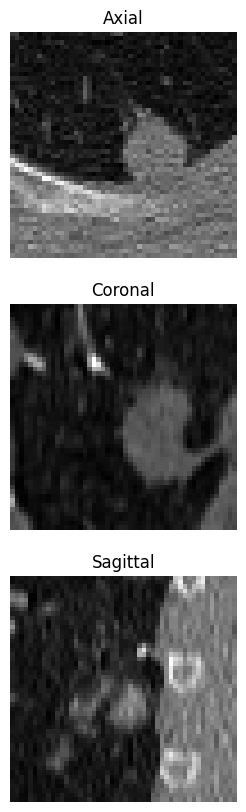

In [79]:
plot_3d_image(item[0])


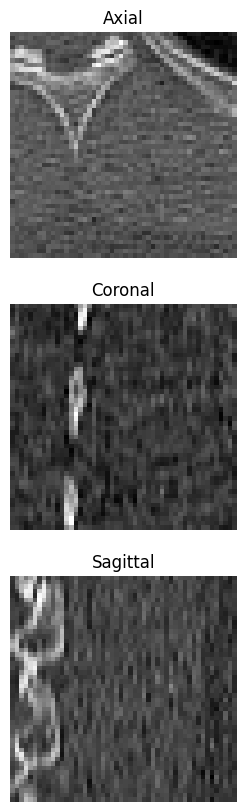

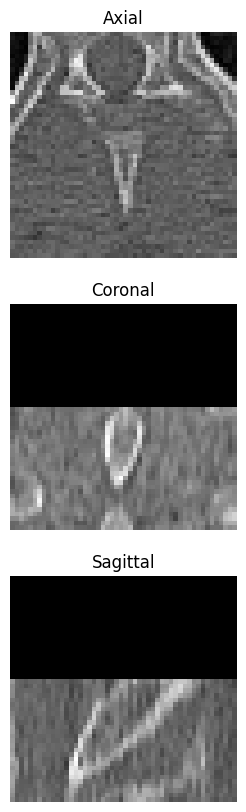

In [80]:
for i in range(1, 3):
    plot_3d_image(item[i])